# Árboles de Clasificación

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)

In [2]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("file:/home/cloudera/Documents/Ficheros de trabajo/bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

In [3]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='UniqueCarrier',outputCol='IndexUniqueCarrier') #el índice empieza en el 0!
bd6=indexer.fit(bd5).transform(bd5)

bd6.groupBy('UniqueCarrier','IndexUniqueCarrier').count().sort('IndexUniqueCarrier').show()


+-------------+------------------+-----+
|UniqueCarrier|IndexUniqueCarrier|count|
+-------------+------------------+-----+
|           AA|               0.0| 8853|
|           UA|               1.0| 6112|
|           WN|               2.0| 5395|
|           DL|               3.0| 4239|
|           VX|               4.0| 1703|
|           NK|               5.0| 1581|
|           F9|               6.0| 1295|
|           OO|               7.0| 1166|
|           B6|               8.0|  121|
|           EV|               9.0|    1|
+-------------+------------------+-----+



## Ajuste del modelo

In [4]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import col

a1  = VectorAssembler(
    inputCols=['DepDelay','Distance','DayOfWeek',
               'CRSDepTime','IndexUniqueCarrier'],
    outputCol='features')

bd7 = a1.transform(bd6).select(col("Retraso").cast('double').alias("label"),'features')

stringIndexer = StringIndexer(inputCol = 'label', outputCol = 'label2')
sI = stringIndexer.fit(bd7)
bd7 = sI.transform(bd7)



### Partición Test - Train

In [5]:
(bd_train, bd_test) = bd7.randomSplit([0.7, 0.3],seed=123)
print(bd_train.count())
print(bd_test.count())

21353
9113


In [6]:
from pyspark.ml.classification import DecisionTreeClassifier as DTC

rt = DTC(maxDepth=5, labelCol = 'label2')

model = rt.fit(bd_train)
pred = model.transform(bd_train)

In [7]:
pred.show()

+-----+--------------------+------+--------------+--------------------+----------+
|label|            features|label2| rawPrediction|         probability|prediction|
+-----+--------------------+------+--------------+--------------------+----------+
|  0.0|[-15.0,1464.0,6.0...|   0.0|[2243.0,143.0]|[0.94006705783738...|       0.0|
|  0.0|[-11.0,236.0,2.0,...|   0.0|[5552.0,223.0]|[0.96138528138528...|       0.0|
|  0.0|[-11.0,651.0,5.0,...|   0.0|[5552.0,223.0]|[0.96138528138528...|       0.0|
|  0.0|[-10.0,255.0,5.0,...|   0.0|[5552.0,223.0]|[0.96138528138528...|       0.0|
|  0.0|[-10.0,414.0,6.0,...|   0.0|[5552.0,223.0]|[0.96138528138528...|       0.0|
|  0.0|[-10.0,862.0,2.0,...|   0.0|[5552.0,223.0]|[0.96138528138528...|       0.0|
|  0.0|[-10.0,1846.0,5.0...|   0.0|[2243.0,143.0]|[0.94006705783738...|       0.0|
|  0.0|[-9.0,236.0,3.0,7...|   0.0|[5552.0,223.0]|[0.96138528138528...|       0.0|
|  0.0|[-9.0,255.0,2.0,2...|   0.0|[5552.0,223.0]|[0.96138528138528...|       0.0|
|  0

In [8]:
pred.groupBy('probability').count().show(50)


+--------------------+-----+
|         probability|count|
+--------------------+-----+
|[0.78490566037735...|  265|
|[0.82188295165394...|  393|
|[0.93495674463313...| 3121|
|[0.16049382716049...|   81|
|[0.05263157894736...|  285|
|[0.35483870967741...|  155|
|           [0.0,1.0]| 2491|
|[0.44148936170212...|  188|
|           [0.5,0.5]|    4|
|[0.00468384074941...|  427|
|           [1.0,0.0]|    7|
|[0.96138528138528...| 5775|
|[0.60777385159010...|  566|
|     [0.3125,0.6875]|  128|
|[0.45454545454545...|   33|
|[0.53103448275862...|  145|
|[0.72670807453416...|  161|
|[0.31282051282051...|  195|
|[0.88073394495412...|  763|
|[0.88635210553018...| 1971|
|[0.94006705783738...| 2386|
|[0.48148148148148...|   27|
|[0.68315018315018...|  546|
|[0.06338028169014...|  142|
|         [0.08,0.92]|   25|
|[0.19078947368421...|  152|
|[0.35294117647058...|   17|
|[0.72602739726027...|   73|
|[0.02173913043478...|  138|
|[0.80984340044742...|  447|
|[0.97560975609756...|   41|
|[0.1317073170

In [9]:
pred.groupBy('label','prediction').count().show()
#threshold = 0.5

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 4316|
|  0.0|       0.0|15038|
|  0.0|       1.0|  373|
|  1.0|       0.0| 1626|
+-----+----------+-----+



### Curva ROC

In [10]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

secondelement=udf(lambda v:float(v[1]),FloatType())
pred2=pred.withColumn('probs',secondelement('probability'))

pred2.show(10)

+-----+--------------------+------+--------------+--------------------+----------+-----------+
|label|            features|label2| rawPrediction|         probability|prediction|      probs|
+-----+--------------------+------+--------------+--------------------+----------+-----------+
|  0.0|[-15.0,1464.0,6.0...|   0.0|[2243.0,143.0]|[0.94006705783738...|       0.0|0.059932943|
|  0.0|[-11.0,236.0,2.0,...|   0.0|[5552.0,223.0]|[0.96138528138528...|       0.0| 0.03861472|
|  0.0|[-11.0,651.0,5.0,...|   0.0|[5552.0,223.0]|[0.96138528138528...|       0.0| 0.03861472|
|  0.0|[-10.0,255.0,5.0,...|   0.0|[5552.0,223.0]|[0.96138528138528...|       0.0| 0.03861472|
|  0.0|[-10.0,414.0,6.0,...|   0.0|[5552.0,223.0]|[0.96138528138528...|       0.0| 0.03861472|
|  0.0|[-10.0,862.0,2.0,...|   0.0|[5552.0,223.0]|[0.96138528138528...|       0.0| 0.03861472|
|  0.0|[-10.0,1846.0,5.0...|   0.0|[2243.0,143.0]|[0.94006705783738...|       0.0|0.059932943|
|  0.0|[-9.0,236.0,3.0,7...|   0.0|[5552.0,223.0]|

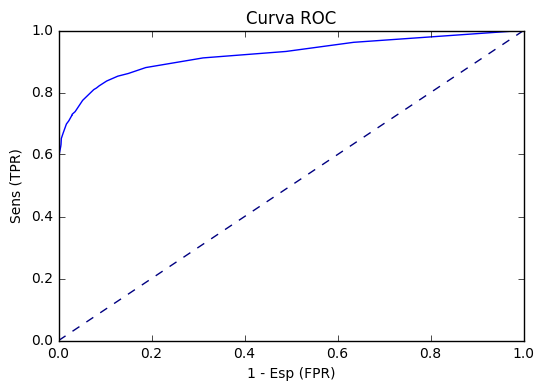

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import seaborn as sns

pd5 = pred2.sample(False,0.1).select('label','probs').toPandas()

fpr, tpr, _ = roc_curve( pd5['label'], pd5['probs'])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('1 - Esp (FPR)')
plt.ylabel('Sens (TPR)')
plt.title('Curva ROC')
plt.show()

In [12]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

print('AUC=',BCE(metricName="areaUnderROC",rawPredictionCol = 'probability').evaluate(pred))


AUC= 0.9201656831035615


In [13]:
# DecisionTreeClassifier(featuresCol="features",
#    labelCol="label",
#    predictionCol="prediction",
#    probabilityCol="probability",
#    rawPredictionCol="rawPrediction",
#    maxDepth=5,
#    maxBins=32,
#    minInstancesPerNode=1,
#    minInfoGain=0.0,
#    maxMemoryInMB=256,
#    impurity="gini"  / impurity="entropy" )

In [14]:
rt = DTC(maxDepth=20, labelCol = 'label2')
model = rt.fit(bd_train)
pred = model.transform(bd_train)

print('AUC=',BCE(metricName="areaUnderROC", rawPredictionCol = 'probability').evaluate(pred))

AUC= 0.9995937684642632


### Validación externa

In [15]:
predtest = model.transform(bd_test)

print('AUC=',BCE(metricName="areaUnderROC",rawPredictionCol = 'probability').evaluate(predtest))

AUC= 0.8258884845826836
